In [ ]:
pip install polars numpy implicit tqdm

In [1]:
import polars as pl
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
import implicit
import pandas as pd

RANDOM_STATE = 42
N_PREDICTIONS = 100


In [42]:
import seaborn as sns
sns.set()

### Чтение и подготовка данных для анализа 

In [3]:
df_names = pd.read_json('/Users/anastasiakucina/hahaha/names (3).jsonl')

In [4]:
df_names.head(10)

,clean_names,slash_names,parenthesis
0,Смотритель музейный,[],[]
1,Ведущий менеджер по работе с физическими лицами,[],[]
2,Бухгалтер,[],[по расчету зарплаты]
3,Пекарь,[],"[Токсово, Привокзальная, 16]"
4,Торговый представитель,[],[г. Абакан]
5,Менеджер по качеству,[],[]
6,Менеджер по продажам,[Sales manager],[]
7,Врач по ЛФК,[],[]
8,Монтажник СТиЖБК,[],[]
9,Подсобный рабочий,[],[строительный объект]


In [6]:
df_vacancies = pd.read_json('/Users/anastasiakucina/hahaha/vacancies_no_description.jsonl')

In [7]:
df_vacancies.head()

,vacancy_id,name,company.id,keySkills.keySkill,compensation.from,compensation.to,compensation.currencyCode,area.id,area.regionId,employment,workSchedule,workExperience
0,v_862116,Смотритель музейный,c_162972,"[Пользователь ПК, Работа в команде, Умение пла...",16500.0,NaN,RUR,a_4761,ar_33,full,fullDay,noExperience
1,v_288642,Ведущий менеджер по работе с физическими лицами,c_208672,"[Активные продажи, Холодные продажи, Кредитные...",50000.0,NaN,RUR,a_744,ar_2,full,fullDay,noExperience
2,v_1840054,Бухгалтер (по расчету зарплаты),c_198109,None,50000.0,65000.0,RUR,a_6223,ar_78,full,fullDay,between3And6
3,v_2346232,"Пекарь (Токсово, Привокзальная, 16)",c_6137,None,38500.0,42000.0,RUR,a_4795,ar_51,full,fullDay,noExperience
4,v_312507,Торговый представитель (г. Абакан),c_206699,"[Продуктивность, Клиентоориентированность, Упр...",60000.0,NaN,RUR,a_6837,ar_4,full,fullDay,between1And3


In [8]:
df_vacancies['clean_name'] = df_names['clean_names']

In [28]:
df_vacancies.rename(columns={"company.id": "company_id", "keySkills.keySkill": "keySkills", "compensation.from":"compensation_from", "compensation.to":"compensation_to", "compensation.currencyCode":"compensation_currencyCode", "area.id": "area_id",  "area.regionId" : 'area_regionId'}, inplace = True)

In [41]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_vacancies['employment_encoder'] = labelencoder.fit_transform(df_vacancies['employment'].values)
df_vacancies['workSchedule_encoder'] = labelencoder.fit_transform(df_vacancies['workSchedule'].values)
df_vacancies['workExperience_encoder'] = labelencoder.fit_transform(df_vacancies['workExperience'].values)
df_vacancies['compensation_currencyCode_encoder'] = labelencoder.fit_transform(df_vacancies['compensation_currencyCode'].values)


df_vacancies.head()

,vacancy_id,name,company_id,keySkills,compensation_from,compensation_to,compensation_currencyCode,area_id,area_regionId,employment,workSchedule,workExperience,clean_name,employment_encoder,workSchedule_encoder,workExperience_encoder,compensation_currencyCode_encoder
0,v_862116,Смотритель музейный,c_162972,"[Пользователь ПК, Работа в команде, Умение пла...",16500.0,NaN,RUR,a_4761,ar_33,full,fullDay,noExperience,Смотритель музейный,0,2,3,6
1,v_288642,Ведущий менеджер по работе с физическими лицами,c_208672,"[Активные продажи, Холодные продажи, Кредитные...",50000.0,NaN,RUR,a_744,ar_2,full,fullDay,noExperience,Ведущий менеджер по работе с физическими лицами,0,2,3,6
2,v_1840054,Бухгалтер (по расчету зарплаты),c_198109,None,50000.0,65000.0,RUR,a_6223,ar_78,full,fullDay,between3And6,Бухгалтер,0,2,1,6
3,v_2346232,"Пекарь (Токсово, Привокзальная, 16)",c_6137,None,38500.0,42000.0,RUR,a_4795,ar_51,full,fullDay,noExperience,Пекарь,0,2,3,6
4,v_312507,Торговый представитель (г. Абакан),c_206699,"[Продуктивность, Клиентоориентированность, Упр...",60000.0,NaN,RUR,a_6837,ar_4,full,fullDay,between1And3,Торговый представитель,0,2,0,6


In [48]:
df_vacancies['area_regionId_encoder'] = labelencoder.fit_transform(df_vacancies['area_regionId'].values)
df_vacancies['area_id_encoder'] = labelencoder.fit_transform(df_vacancies['area_id'].values)
df_vacancies['company_id_encoder'] = labelencoder.fit_transform(df_vacancies['company_id'].values)


### Общие статистики 

<Axes: >

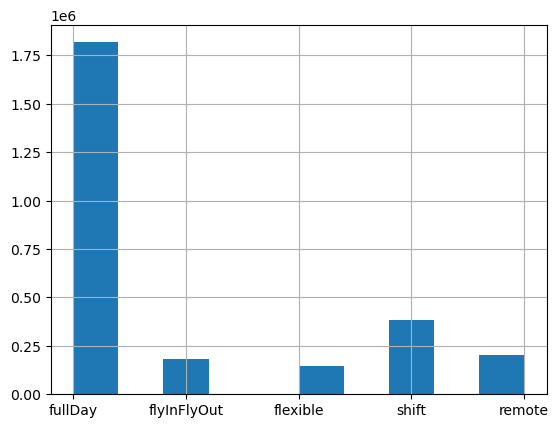

In [35]:
df_vacancies['workSchedule'].hist()

<Axes: >

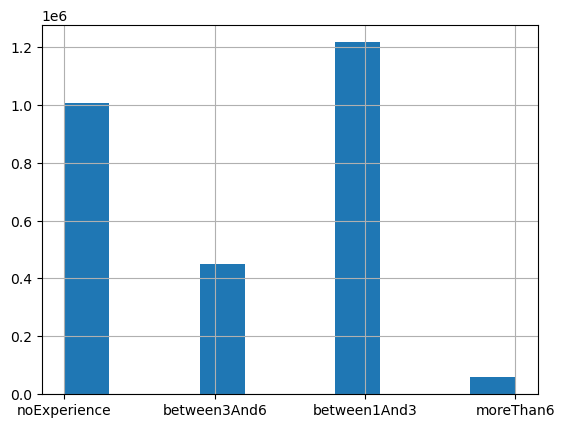

In [36]:
df_vacancies['workExperience'].hist()

<Axes: >

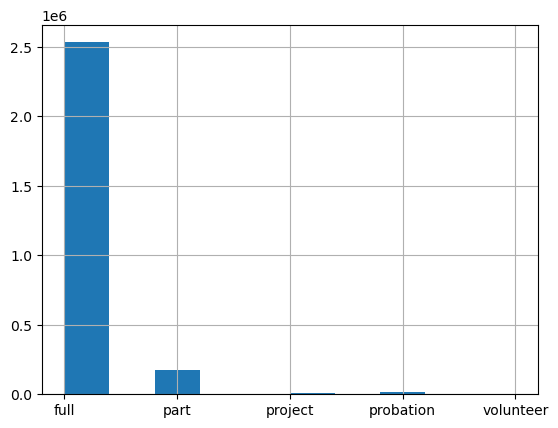

In [37]:
df_vacancies['employment'].hist()

In [30]:
# статистика зп по указанной в описание валюте 
pd.pivot_table(df_vacancies, index = ['compensation_currencyCode'], values = ['compensation_from', 'compensation_to' ], aggfunc = ['mean', 'median'])

mean                            median  \
                          compensation_from compensation_to compensation_from   
compensation_currencyCode                                                       
AZN                            7.333333e+02    1.750000e+03             600.0   
BYR                            2.082744e+03    2.588333e+03            1500.0   
EUR                            6.281267e+03    4.020837e+03            2000.0   
GEL                            5.413783e+03    9.000000e+02             900.0   
KGS                            5.256894e+04    5.934722e+04           40000.0   
KZT                            2.810184e+05    4.469903e+05          252450.0   
RUR                            6.736475e+04    9.428630e+04           55000.0   
UAH                            3.272000e+04    6.750000e+04           35000.0   
USD                            2.001124e+03    3.163675e+03            1500.0   
UZS                            6.190197e+06    9.705520e+06         6000000.0   

                                           
                          compensation_to  
compensation_currencyCode                  
AZN                                1500.0  
BYR                                2500.0  
EUR                                3000.0  
GEL                                 900.0  
KGS                               40000.0  
KZT                              350000.0  
RUR                               70000.0  
UAH                               67500.0  
USD                                2400.0  
UZS                            10000000.0

In [33]:
# статистика региона и города  по указанной в описание валюте 
pd.pivot_table(df_vacancies, index = ['compensation_currencyCode'], values = ['area_id', 'area_regionId' ], aggfunc = ['count'])

count              
                           area_id area_regionId
compensation_currencyCode                       
AZN                              4             0
BYR                            797           142
EUR                           1402           737
GEL                             23             0
KGS                             81             4
KZT                           1571             4
RUR                        2209572       2202882
UAH                              6             6
USD                           7088          3807
UZS                            222             1

In [39]:
### Вывод: сильно доминирует русский рынок 
### Статистика по расписанию с учетом валюты зп 
pd.pivot_table(df_vacancies, index = ['compensation_currencyCode', 'workSchedule'], values = ['name' ], aggfunc = ['count'])

count
                                           name
compensation_currencyCode workSchedule         
AZN                       flexible            1
                          fullDay             2
                          remote              1
BYR                       flexible          233
                          flyInFlyOut        31
                          fullDay           153
                          remote            310
                          shift              70
EUR                       flexible           62
                          flyInFlyOut        15
                          fullDay           783
                          remote            526
                          shift              16
GEL                       flexible            2
                          fullDay            12
                          remote              1
                          shift               8
KGS                       flexible            2
                          flyInFlyOut        20
                          fullDay            35
                          remote             20
                          shift               4
KZT                       flexible          230
                          flyInFlyOut       176
                          fullDay           720
                          remote            341
                          shift             104
RUR                       flexible       122377
                          flyInFlyOut    160114
                          fullDay       1417696
                          remote         148380
                          shift          361005
UAH                       fullDay             4
                          shift               2
USD                       flexible          215
                          flyInFlyOut        74
                          fullDay          3165
                          remote           3498
                          shift             136
UZS                       flexible           43
                          flyInFlyOut         3
                          fullDay           145
                          remote             26
                          shift               5

### Корреляционный анализ 


In [49]:
numeric = ['employment_encoder', 'workSchedule_encoder', 'workExperience_encoder', 'compensation_currencyCode_encoder', 'compensation_from', 'compensation_to', 'company_id_encoder', 'area_id_encoder', 'area_regionId_encoder']



In [50]:
df_vacancies[numeric].corr(method='spearman')

,employment_encoder,workSchedule_encoder,workExperience_encoder,compensation_currencyCode_encoder,compensation_from,compensation_to,company_id_encoder,area_id_encoder,area_regionId_encoder
employment_encoder,1.000000,-0.129929,0.182984,-0.011772,-0.114094,-0.015009,-0.027859,0.005318,0.005939
workSchedule_encoder,-0.129929,1.000000,0.046358,-0.040863,-0.248605,-0.230606,-0.011656,-0.007856,0.028131
workExperience_encoder,0.182984,0.046358,1.000000,-0.110838,-0.244719,-0.190832,0.004490,0.036309,0.012403
compensation_currencyCode_encoder,-0.011772,-0.040863,-0.110838,1.000000,-0.062719,-0.073870,-0.007729,-0.104370,-0.025603
compensation_from,-0.114094,-0.248605,-0.244719,-0.062719,1.000000,0.872022,-0.010386,-0.109775,-0.036187
compensation_to,-0.015009,-0.230606,-0.190832,-0.073870,0.872022,1.000000,-0.002767,-0.112115,-0.038473
company_id_encoder,-0.027859,-0.011656,0.004490,-0.007729,-0.010386,-0.002767,1.000000,-0.000216,0.002429
area_id_encoder,0.005318,-0.007856,0.036309,-0.104370,-0.109775,-0.112115,-0.000216,1.000000,0.143468
area_regionId_encoder,0.005939,0.028131,0.012403,-0.025603,-0.036187,-0.038473,0.002429,0.143468,1.000000


In [ ]:
sns.pairplot(df_vacancies[numeric])